# Domain rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import threatgraph
from scipy import stats

In [2]:
# Number of 'top domains'
n = 10000

In [3]:
g = threatgraph.Gaffer()
g.use_cert()

In [4]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("dnsquery")
                ], entities=None, include="OUTGOING")
            ]), 
             gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("indomain", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

things = {}
timestamps = {}
counts = {}

all_things = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    thing = list(ent["entities"][3].keys())[0]
    
    k = (dev, thing)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in things:
        things[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    things[dev].add(thing)
    all_things.add(thing)
    all_devices.add(dev)

In [5]:
all_devices = list(all_devices)
all_things = list(all_things)

## Construct domain to device matrix

In [6]:
def get_counts(thing, dev):
    if thing in things[dev]: return counts[(dev, thing)]
    return 0

datas = [ [ get_counts(thing, dev) for dev in all_devices ] for thing in all_things]
df = pd.DataFrame(datas, index=all_things, columns=all_devices)

# Add a score column
df["score"] = df.sum(axis=1)
df

,traverses-mac,essential-mac,terrestrial-mac,dgmac,rarb-mac,elysium-mac,turing-chromebook,MalcomWare-PC,dramatic-mac,tirasse-mac,...,essential-cb,ludicrous-mac,raymond-mac,calcannea-mac,minesweepers-mac,DESKTOP-PIMD8C0,abroad-android,serotinal-mac,LAPTOP-1I501C4U,score
mybabygiggles.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
ufocongress.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
bbcimg.co.uk,0,0,0,0,0,0,2,0,0,1,...,8,0,0,1,0,0,0,0,0,24
blrlvebujd.openvpn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
turnersims.co.uk,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
joomlatune.com,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
dca.ru,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
vmweb.net,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
algovid.com,0,0,0,0,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,27
elliottbaybook.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


## Get list of highest accessed domains by all devices

In [7]:
top_domains = df.sort_values(by="score", ascending=False).index.values[:n]
top_domains

array(['google.com', 'gstatic.com', 'googleapis.com', ...,
       'pastemagazine.com', 'modelrailroader.com',
       'innovativeadserver.com'], dtype=object)

## Spearman's Rho

In [8]:
# Calculate Rho on 2 lists
def spearman(a, b):
    
    n = max(len(a), len(b))
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = n
        val = val * val
        
        tot += val
        
    for i in range(len(a), len(b)):
        tot += len(b) * len(b)
        
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

## Get favourite domains by device

In [9]:
fav_domains = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_domains

[['traverses-mac',
  array(['google.com', 'apple.com', 'in-addr.arpa', ..., 'aol.co.uk',
         'allaboutmalvernhills.com', 'innovativeadserver.com'], dtype=object)],
 ['essential-mac',
  array(['apple.com', 'google.com', 'in-addr.arpa', ..., 'lodash.com',
         'simonpegg.net', 'innovativeadserver.com'], dtype=object)],
 ['terrestrial-mac',
  array(['google.com', 'gstatic.com', 'apple.com', ..., 'wurfl.io',
         'shoofle.tv', 'innovativeadserver.com'], dtype=object)],
 ['dgmac', array(['google.com', 'apple.com', 'clubhouse.io', ..., 'aol.co.uk',
         'allaboutmalvernhills.com', 'innovativeadserver.com'], dtype=object)],
 ['rarb-mac',
  array(['google.com', 'in-addr.arpa', 'apple.com', ..., 'bbckids.ca',
         'stumbleupon.com', 'innovativeadserver.com'], dtype=object)],
 ['elysium-mac', array(['google.com', 'gstatic.com', 'googleapis.com', ...,
         'scarabresearch.com', 'bhmyajo.local', 'innovativeadserver.com'],
        dtype=object)],
 ['turing-chromebook',
  ar

In [10]:
df2 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
df2

,domains
device,
traverses-mac,"[google.com, apple.com, in-addr.arpa, akadns.n..."
essential-mac,"[apple.com, google.com, in-addr.arpa, icloud.c..."
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi..."
dgmac,"[google.com, apple.com, clubhouse.io, github.c..."
rarb-mac,"[google.com, in-addr.arpa, apple.com, googleap..."
elysium-mac,"[google.com, gstatic.com, googleapis.com, goog..."
turing-chromebook,"[google.com, googleapis.com, gstatic.com, slac..."
MalcomWare-PC,"[ddns.net, trustnetworks.com, microsoft.com, g..."
dramatic-mac,"[google.com, apple.com, rbxcdn.com, amazonaws...."


## Compute Spearman co-efficient
against most common domains

In [11]:
df2["coefficient"] = df2["domains"].apply(lambda x: spearman(x, top_domains)).round(2)

In [12]:
df2.sort_values(by="coefficient", ascending=False)[["domains", "coefficient"]]

,domains,coefficient
device,,
misskitty-mac,"[google.com, akadns.net, gstatic.com, googleap...",0.50
steamverne-mac,"[google.com, doubleclick.net, gstatic.com, goo...",0.33
minesweepers-mac,"[google.com, github.com, in-addr.arpa, clubhou...",0.29
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",0.27
languid-mac,"[google.com, apple.com, in-addr.arpa, gstatic....",0.27
boundless-mac,"[google.com, in-addr.arpa, apple.com, clubhous...",0.27
dramatic-mac,"[google.com, apple.com, rbxcdn.com, amazonaws....",0.24
mark-mac,"[facebook.com, virustotal.com, google.com, twi...",0.22
serotinal-mac,"[google.com, googleapis.com, in-addr.arpa, gst...",0.22


## Device to device co-efficient

In [13]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
df3 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
for dev, domains in everyone:
    df3[dev] = df3["domains"].apply(lambda x: spearman(domains, x)).round(2)

In [14]:
df3

,domains,traverses-mac,essential-mac,terrestrial-mac,dgmac,rarb-mac,elysium-mac,turing-chromebook,MalcomWare-PC,dramatic-mac,...,languid-mac,essential-cb,ludicrous-mac,raymond-mac,calcannea-mac,minesweepers-mac,DESKTOP-PIMD8C0,abroad-android,serotinal-mac,LAPTOP-1I501C4U
device,,,,,,,,,,,,,,,,,,,,,
traverses-mac,"[google.com, apple.com, in-addr.arpa, akadns.n...",1.00,0.98,0.52,0.97,0.94,0.63,0.92,0.94,0.58,...,0.65,0.69,0.98,0.73,0.95,0.62,0.84,0.94,0.63,0.84
essential-mac,"[apple.com, google.com, in-addr.arpa, icloud.c...",0.98,1.00,0.51,0.97,0.93,0.63,0.91,0.94,0.57,...,0.64,0.69,0.98,0.73,0.95,0.61,0.84,0.94,0.63,0.84
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",0.52,0.51,1.00,0.52,0.54,0.57,0.55,0.54,0.54,...,0.65,0.55,0.52,0.59,0.53,0.61,0.58,0.54,0.57,0.58
dgmac,"[google.com, apple.com, clubhouse.io, github.c...",0.97,0.97,0.52,1.00,0.93,0.63,0.92,0.94,0.58,...,0.65,0.70,0.98,0.73,0.97,0.63,0.85,0.94,0.64,0.85
rarb-mac,"[google.com, in-addr.arpa, apple.com, googleap...",0.94,0.93,0.54,0.93,1.00,0.65,0.93,0.92,0.59,...,0.67,0.71,0.94,0.74,0.93,0.65,0.85,0.92,0.65,0.85
elysium-mac,"[google.com, gstatic.com, googleapis.com, goog...",0.63,0.63,0.57,0.63,0.65,1.00,0.66,0.65,0.58,...,0.71,0.64,0.64,0.66,0.65,0.67,0.68,0.66,0.68,0.68
turing-chromebook,"[google.com, googleapis.com, gstatic.com, slac...",0.92,0.91,0.55,0.92,0.93,0.66,1.00,0.90,0.60,...,0.69,0.71,0.92,0.74,0.92,0.65,0.85,0.92,0.66,0.85
MalcomWare-PC,"[ddns.net, trustnetworks.com, microsoft.com, g...",0.94,0.94,0.54,0.94,0.92,0.65,0.90,1.00,0.60,...,0.67,0.70,0.94,0.74,0.94,0.64,0.88,0.94,0.65,0.88
dramatic-mac,"[google.com, apple.com, rbxcdn.com, amazonaws....",0.58,0.57,0.54,0.58,0.59,0.58,0.60,0.60,1.00,...,0.62,0.57,0.58,0.59,0.59,0.60,0.64,0.59,0.58,0.64


## Plot heatmap

In [15]:
mask = np.zeros_like(df3[all_devices][all_devices])
mask[np.triu_indices_from(mask)] = True

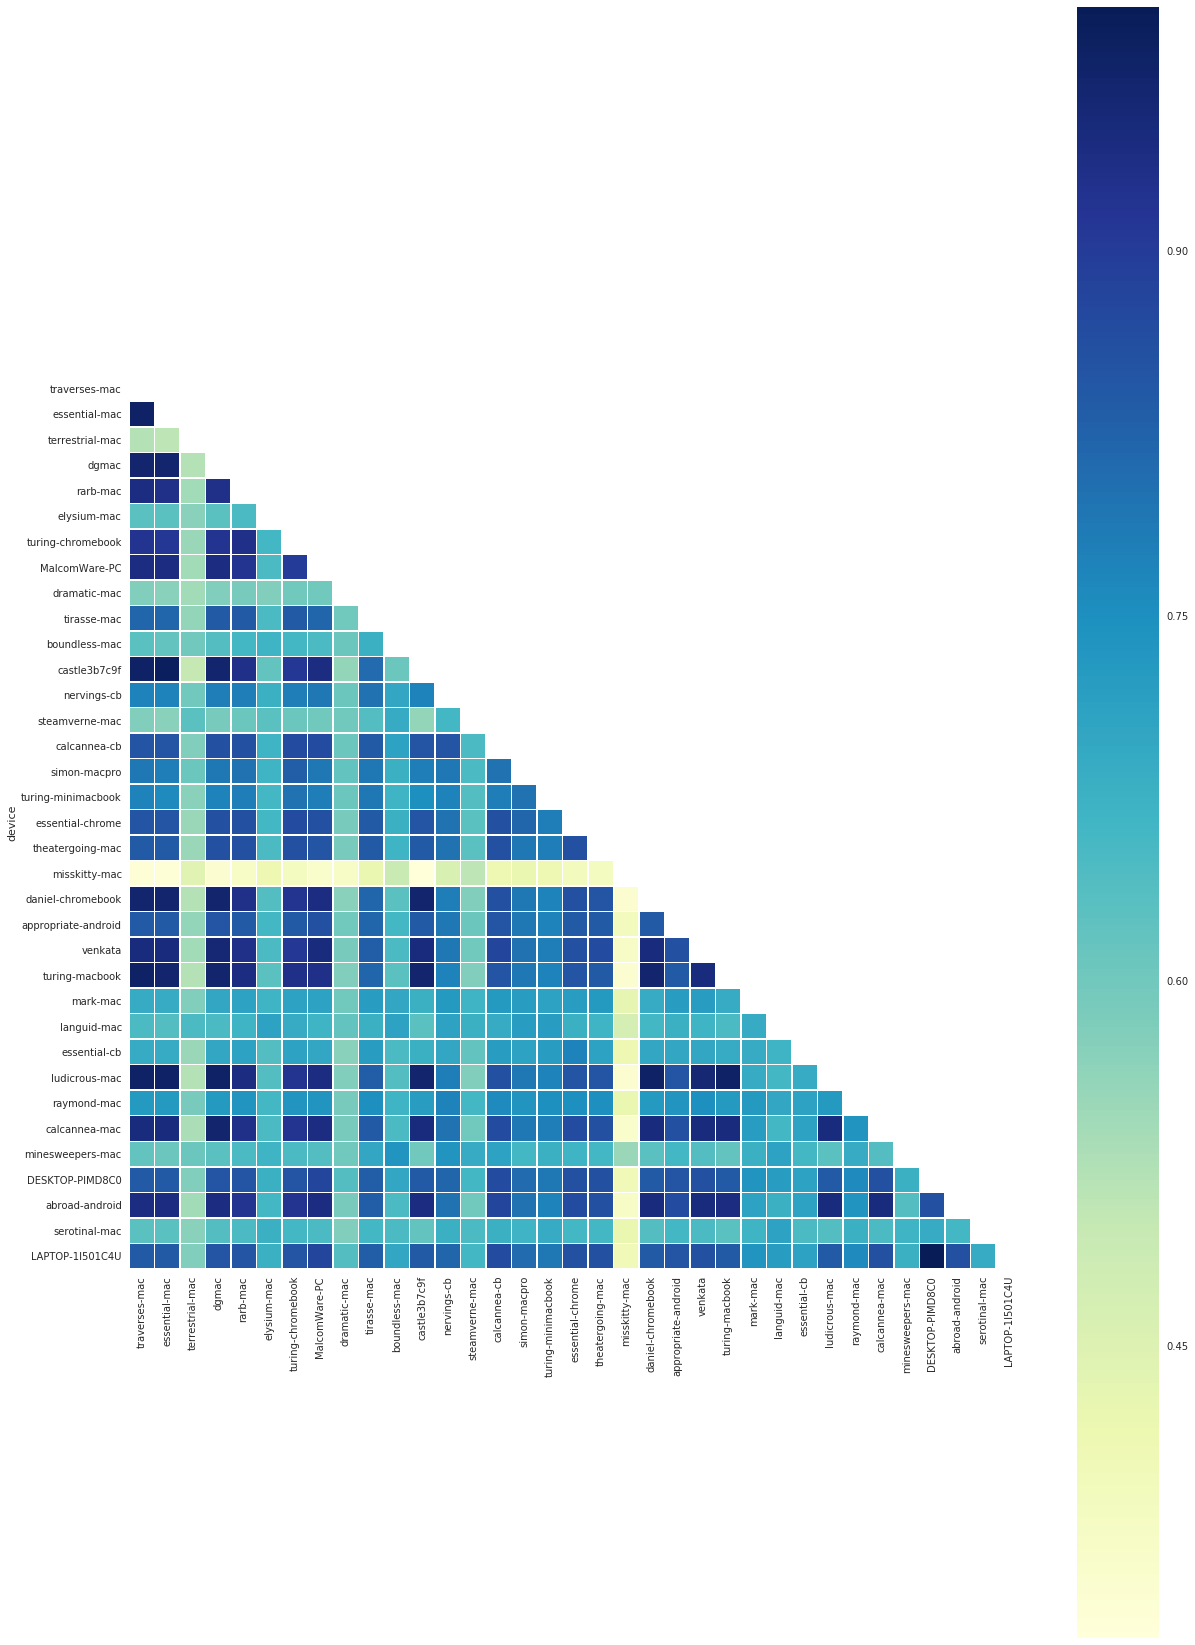

In [16]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()

## Alternative rank correlation

Higher weights nearer the 'top' of the rank list

In [17]:
# Sum of geometric progression
def geosum(a1, r, n):
    return a1 * (1 - r ** n) / (1 - r)

In [18]:
# Calculate Rho on 2 lists
def correlator(a, b):
        
    coeff = 1
    ratio = 0.4
    n = max(len(a), len(b))
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = n
        val = val * val * coeff * (ratio ** i)
        
        tot += val
                
    for i in range(len(a), len(b)):
        tot += len(b) * len(b)
        
    x = 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )
    s = geosum(coeff, ratio, n)
    x /= s
    return x

In [19]:
df3 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
for dev, domains in everyone:
    df3[dev] = df3["domains"].apply(lambda x: correlator(domains, x)).round(6)
df3

,domains,traverses-mac,essential-mac,terrestrial-mac,dgmac,rarb-mac,elysium-mac,turing-chromebook,MalcomWare-PC,dramatic-mac,...,languid-mac,essential-cb,ludicrous-mac,raymond-mac,calcannea-mac,minesweepers-mac,DESKTOP-PIMD8C0,abroad-android,serotinal-mac,LAPTOP-1I501C4U
device,,,,,,,,,,,,,,,,,,,,,
traverses-mac,"[google.com, apple.com, in-addr.arpa, akadns.n...",0.600000,0.599999,0.599995,0.599965,0.600000,0.599998,0.599995,0.599717,0.599998,...,0.600000,0.599985,0.599984,0.599978,0.599991,0.599883,0.599455,0.599925,0.599995,0.599455
essential-mac,"[apple.com, google.com, in-addr.arpa, icloud.c...",0.599998,0.600000,0.599976,0.599965,0.599973,0.599951,0.599882,0.599714,0.599981,...,0.599989,0.599967,0.599976,0.599971,0.599874,0.599884,0.599455,0.599807,0.599877,0.599455
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",0.600000,0.599998,0.600000,0.600000,0.600000,0.599997,0.600000,0.599934,0.599942,...,0.600000,0.600000,0.600000,0.599984,0.599991,0.600000,0.599963,0.599993,0.599996,0.599963
dgmac,"[google.com, apple.com, clubhouse.io, github.c...",0.600000,0.600000,0.599995,0.600000,0.599992,0.599998,0.600000,0.599950,0.599997,...,0.600000,0.600000,0.599983,0.599990,0.599998,0.600000,0.599977,0.599930,0.599995,0.599977
rarb-mac,"[google.com, in-addr.arpa, apple.com, googleap...",0.600000,0.600000,0.599995,0.600000,0.600000,0.599998,0.600000,0.599903,0.599998,...,0.600000,0.600000,0.599998,0.599990,0.599994,0.600000,0.599621,0.599923,0.599995,0.599621
elysium-mac,"[google.com, gstatic.com, googleapis.com, goog...",0.600000,0.599998,0.600000,0.600000,0.599988,0.600000,0.600000,0.599945,0.599994,...,0.600000,0.600000,0.599985,0.599987,0.599994,0.599999,0.599967,0.599994,0.600000,0.599967
turing-chromebook,"[google.com, googleapis.com, gstatic.com, slac...",0.600000,0.600000,0.599995,0.599995,0.599992,0.599998,0.600000,0.599897,0.599997,...,0.600000,0.599987,0.599983,0.599976,0.599994,0.599998,0.599619,0.599923,0.599995,0.599619
MalcomWare-PC,"[ddns.net, trustnetworks.com, microsoft.com, g...",0.599906,0.599865,0.599976,0.599957,0.599821,0.599968,0.599984,0.600000,0.599952,...,0.599915,0.599987,0.599577,0.599973,0.599991,0.599816,0.599976,0.599923,0.599930,0.599976
dramatic-mac,"[google.com, apple.com, rbxcdn.com, amazonaws....",0.600000,0.599996,0.600000,0.599978,0.600000,0.599997,0.599975,0.599733,0.600000,...,0.600000,0.599966,0.599983,0.599972,0.599936,0.599993,0.599783,0.599921,0.599996,0.599783


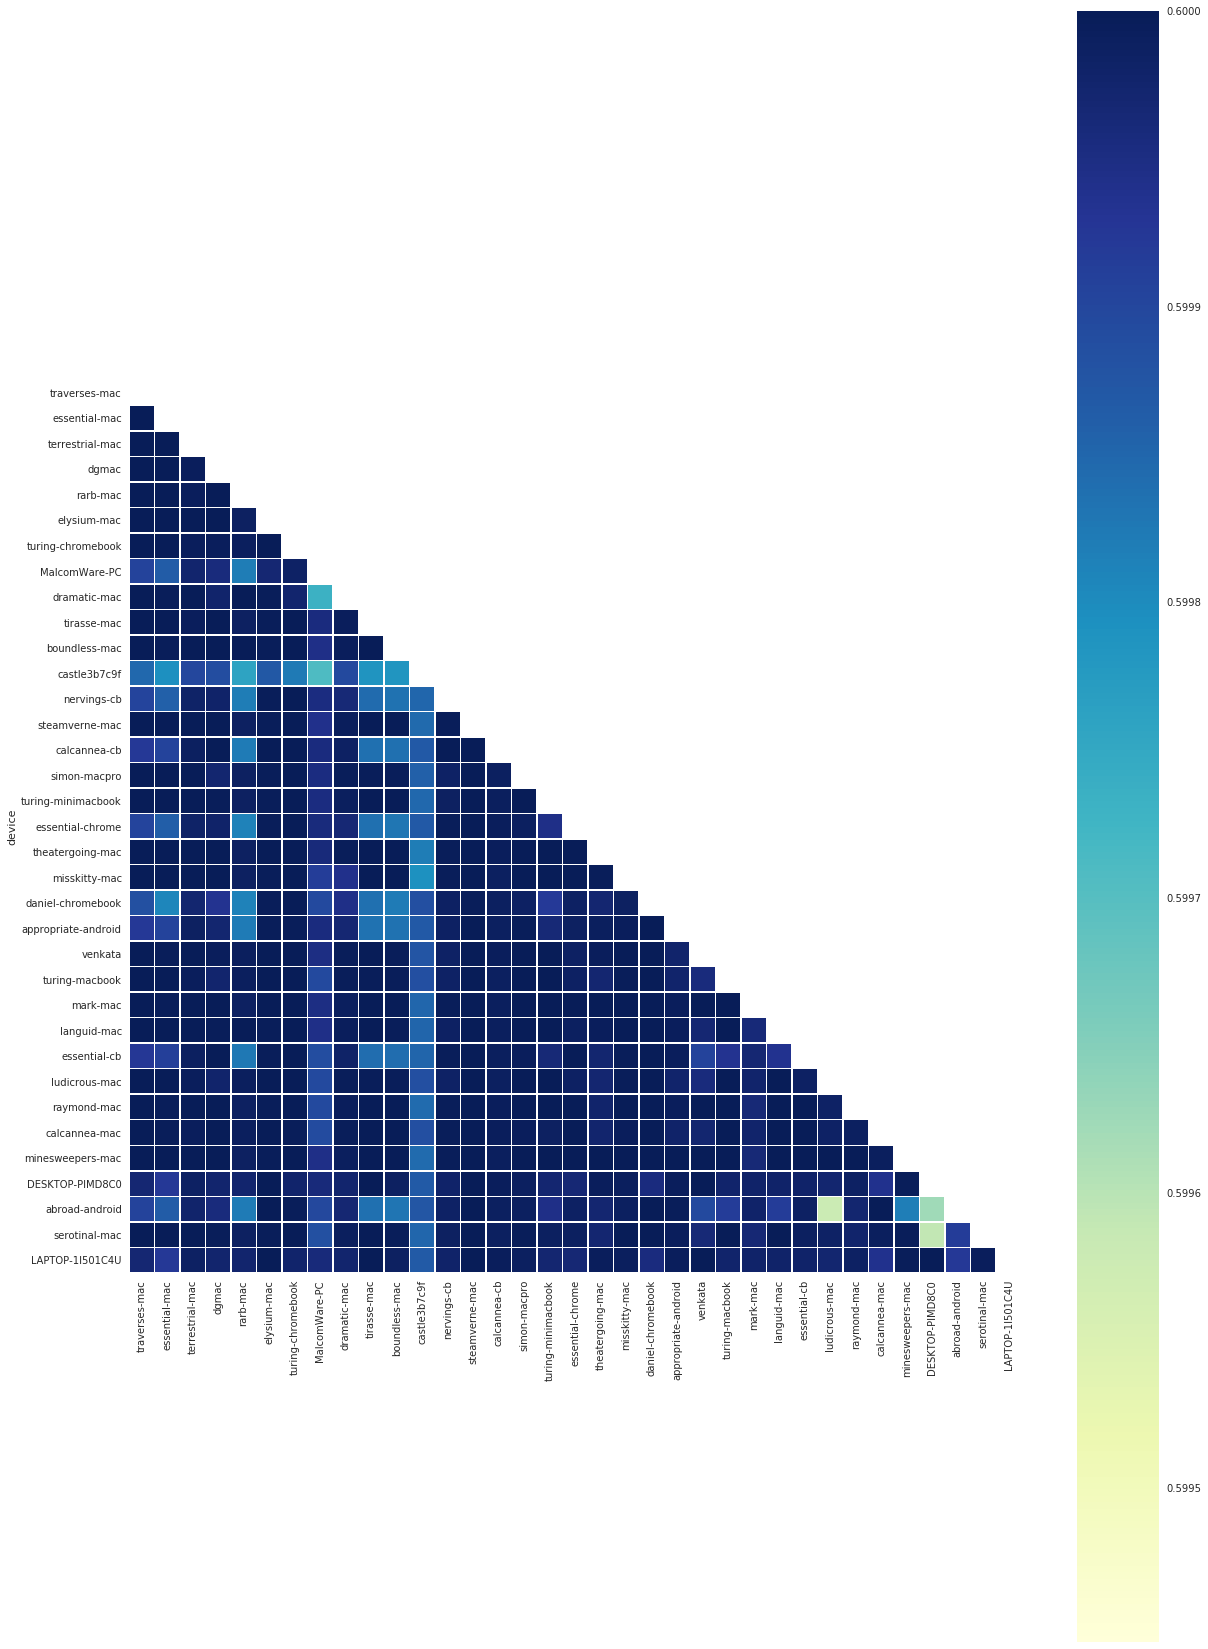

In [20]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()

## Kendall Tau

In [21]:
# Calculate Rho on 2 lists
def correlator(a, b):

    n = max(len(a), len(b))
    
    alst = [v for v in range(0,len(a))]
    amap = {a[i]: i for i in range(0, len(a)) }
    blst = [amap[b[v]] if b[v] in amap else len(a) for v in range(0, len(b))]
    alst.extend([len(a)] * (n - len(a)))
    blst.extend([len(a)] * (n - len(b)))

    tau, p = stats.weightedtau(alst, blst)
  
    return tau

In [22]:
correlator("abcde", "abcdefg")

1.0

In [23]:
df3 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
for dev, domains in everyone:
    df3[dev] = df3["domains"].apply(lambda x: correlator(domains, x)).round(6)
df3

,domains,traverses-mac,essential-mac,terrestrial-mac,dgmac,rarb-mac,elysium-mac,turing-chromebook,MalcomWare-PC,dramatic-mac,...,languid-mac,essential-cb,ludicrous-mac,raymond-mac,calcannea-mac,minesweepers-mac,DESKTOP-PIMD8C0,abroad-android,serotinal-mac,LAPTOP-1I501C4U
device,,,,,,,,,,,,,,,,,,,,,
traverses-mac,"[google.com, apple.com, in-addr.arpa, akadns.n...",1.000000,0.984290,0.608115,0.983957,0.952678,0.709862,0.928046,0.954979,0.557457,...,0.759577,0.739488,0.986859,0.767245,0.961671,0.715775,0.884044,0.961667,0.702214,0.884044
essential-mac,"[apple.com, google.com, in-addr.arpa, icloud.c...",0.984290,1.000000,0.640934,0.978712,0.941783,0.699908,0.924655,0.938699,0.559590,...,0.744615,0.754152,0.976618,0.780443,0.946305,0.727264,0.870590,0.944717,0.702264,0.870590
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",0.608115,0.640934,1.000000,0.609324,0.688067,0.686480,0.713011,0.707304,0.487044,...,0.743061,0.691359,0.607988,0.736402,0.653801,0.776054,0.720858,0.654292,0.716765,0.720858
dgmac,"[google.com, apple.com, clubhouse.io, github.c...",0.983957,0.978712,0.609324,1.000000,0.946089,0.692587,0.926309,0.953458,0.552519,...,0.741157,0.738548,0.983690,0.766959,0.970640,0.714435,0.886296,0.964363,0.686648,0.886296
rarb-mac,"[google.com, in-addr.arpa, apple.com, googleap...",0.952678,0.941783,0.688067,0.946089,1.000000,0.715755,0.959493,0.958605,0.524442,...,0.767544,0.801497,0.955048,0.768922,0.955076,0.723564,0.858765,0.950785,0.710524,0.858765
elysium-mac,"[google.com, gstatic.com, googleapis.com, goog...",0.709862,0.699908,0.686480,0.692587,0.715755,1.000000,0.751957,0.759098,0.628601,...,0.838829,0.777103,0.691831,0.817356,0.755465,0.801304,0.733897,0.756517,0.803455,0.733897
turing-chromebook,"[google.com, googleapis.com, gstatic.com, slac...",0.928046,0.924655,0.713011,0.926309,0.959493,0.751957,1.000000,0.945030,0.553577,...,0.744879,0.810043,0.923579,0.798548,0.944433,0.708144,0.905274,0.936099,0.746516,0.905274
MalcomWare-PC,"[ddns.net, trustnetworks.com, microsoft.com, g...",0.954979,0.938699,0.707304,0.953458,0.958605,0.759098,0.945030,1.000000,0.510779,...,0.777185,0.749925,0.958110,0.808648,0.971980,0.743422,0.904717,0.973549,0.758073,0.904717
dramatic-mac,"[google.com, apple.com, rbxcdn.com, amazonaws....",0.557457,0.559590,0.487044,0.552519,0.524442,0.628601,0.553577,0.510779,1.000000,...,0.637940,0.624132,0.513429,0.611485,0.507639,0.596598,0.593528,0.541516,0.633695,0.593528


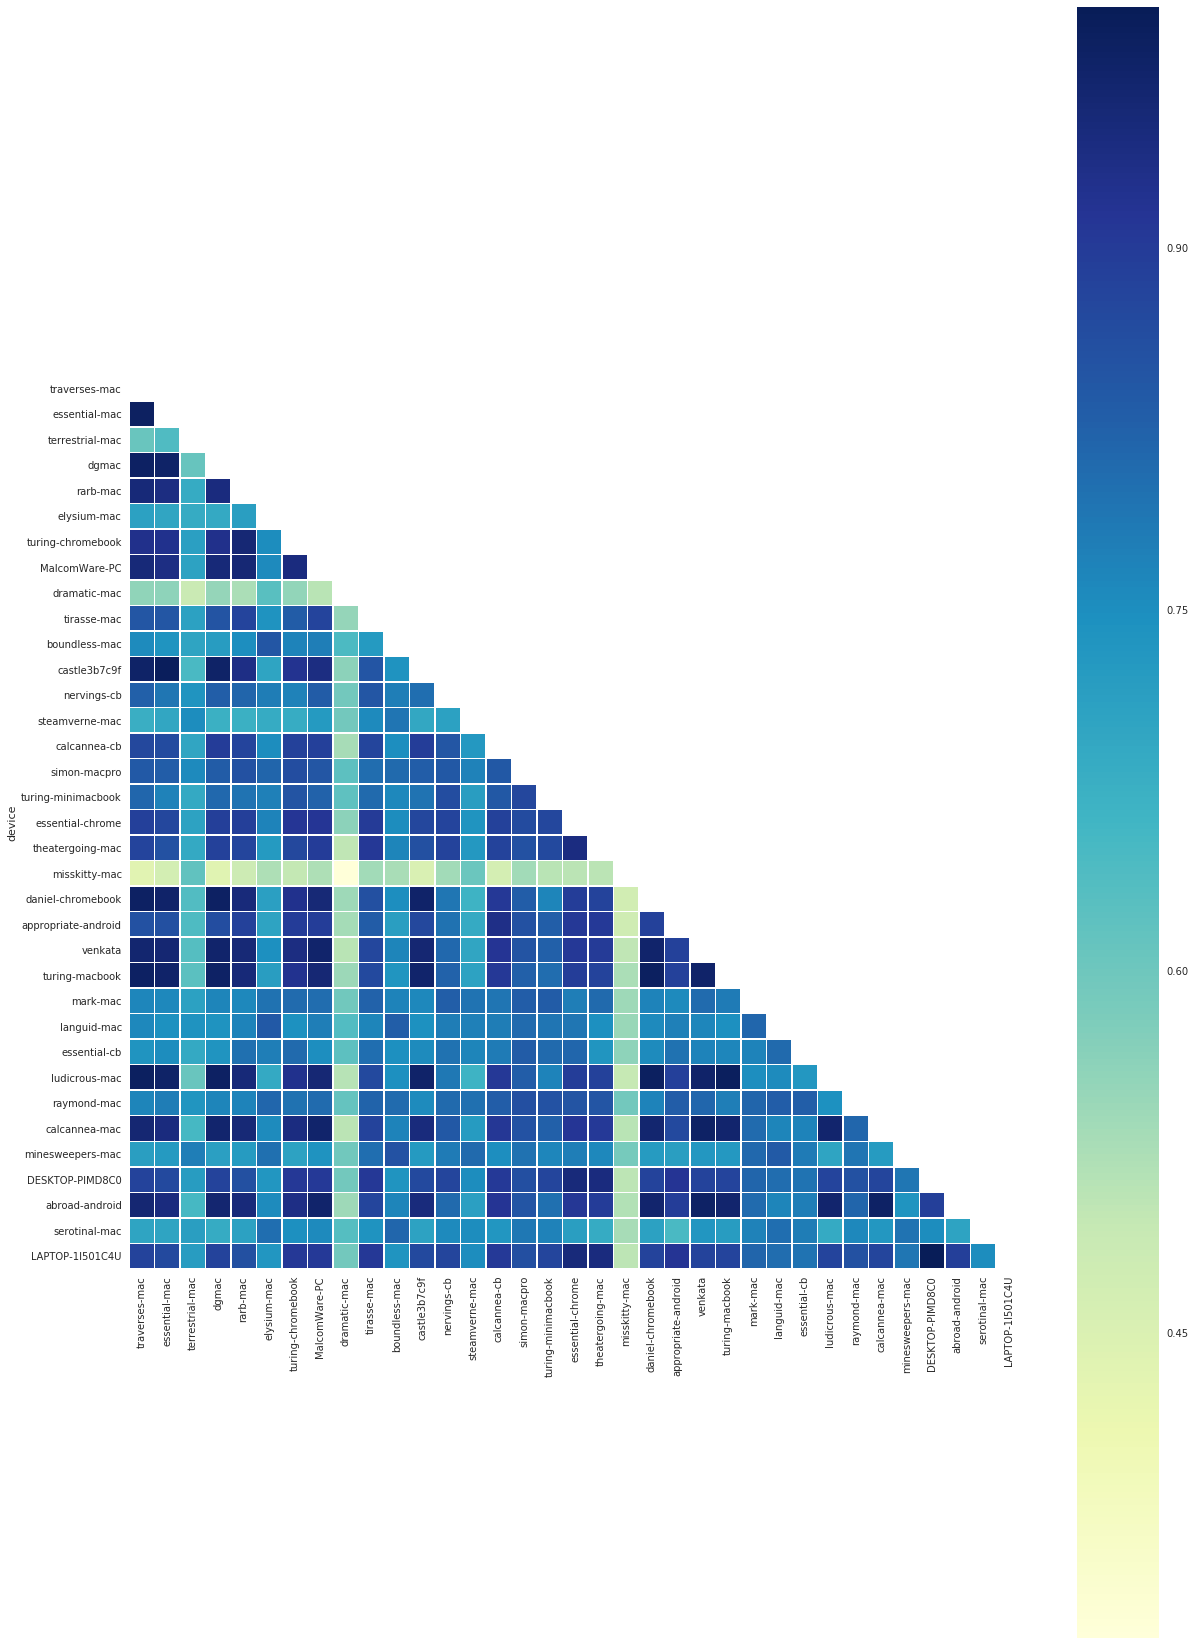

In [24]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()